In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
from tqdm import tqdm
import statistics as stat
import math

# Data Reading

First, we have to create dataframes from the given datasets. We have to sort them, clean them, and combine the relevant data.

In [177]:
# RUN THIS BLOCK FOR ORIGINAL SAMPLE DATA

# Creating dataframe with monthly data for companies
monthly_dataset = pd.read_csv("NL_FR_BE_data_monthly.csv")
monthly_dataset['mdate'] = pd.to_datetime(monthly_dataset['mdate'], format="%Y%m")
monthly_dataset["ISIN"] = monthly_dataset["ISIN"].astype(str) 
monthly_dataset = monthly_dataset.sort_values(["ISIN", "mdate"], ascending=[True, True])       # Sort data by security and date, for easier access
monthly_dataset = monthly_dataset.reset_index()
monthly_dataset = monthly_dataset.drop(["index"], axis = 1)   # Delete duplicate column
monthly_dataset = monthly_dataset.dropna()                            # Just to be sure
print(monthly_dataset.head(3).to_markdown(), "\n")

# Creating annual dataframe for companies
# First we read the given annual data
annual_dataset = pd.read_csv("NL_FR_BE_data_annual.csv")
annual_dataset['fyear'] = pd.to_datetime(annual_dataset['fyear'], format="%Y") + DateOffset(months=5)       # FF data is starting from June
annual_dataset["ISIN"] = annual_dataset["ISIN"].astype(str) 
annual_dataset = annual_dataset.sort_values(["ISIN", "fyear"], ascending=[True, True])       # Sort data by security and date, for easier access
annual_dataset = annual_dataset.reset_index()
annual_dataset = annual_dataset.drop(["index"], axis = 1)                                   # Delete duplicate column
# Next we get relevant data for annual dataframe from the monthly one
monthly_dataset_annual = monthly_dataset.copy()
mask = monthly_dataset_annual['mdate'].dt.month == 6
monthly_dataset_annual = monthly_dataset_annual.loc[mask, :]
monthly_dataset_annual["RET10"] =  monthly_dataset_annual["RET11"] - monthly_dataset_annual["RET"]      # Deleting last month's returns to avoid short term mean-reversion
monthly_dataset_annual["fyear"] = monthly_dataset_annual["mdate"]
monthly_dataset_annual = monthly_dataset_annual.drop(["RET11", "RET", "mdate"], axis = 1)   # Delete duplicate
annual_dataset = annual_dataset.merge(monthly_dataset_annual)       # Final dataset on which we can trade
annual_dataset = annual_dataset.dropna()                            # Just to be sure
print(annual_dataset.head(3).to_markdown(), "\n")

# Finally creating monthly dataframe of the market
monthly_fixed_params = pd.read_csv("Europe_FF_Factors.csv")
monthly_fixed_params['mdate'] = pd.to_datetime(monthly_fixed_params['mdate'], format="%Y%m")
monthly_fixed_params = monthly_fixed_params.sort_values(["mdate"], ascending=[True])       # Sort data by security and date, for easier access
monthly_fixed_params = monthly_fixed_params.reset_index()
monthly_fixed_params = monthly_fixed_params.drop(["index"], axis = 1)   # Delete duplicate column
# Parameters that will be later used to trade (Filters for Signals based on FF)
monthly_fixed_params["b_border"] = np.zeros(len(monthly_fixed_params))
monthly_fixed_params["h_border"] = np.zeros(len(monthly_fixed_params))
monthly_fixed_params["s_border"] = np.zeros(len(monthly_fixed_params))
monthly_fixed_params["ivol_border"] = np.zeros(len(monthly_fixed_params))
print(monthly_fixed_params.head(3).to_markdown(), "\n")

|    | ISIN         | mdate               |     RET |   RET11 |      ME |      b |       h |       s |   ivol |
|---:|:-------------|:--------------------|--------:|--------:|--------:|-------:|--------:|--------:|-------:|
|  0 | ANN4327C1220 | 1991-06-01 00:00:00 | -0.0256 | -0.2089 | 712.452 | 1.2541 | -0.9141 | -0.1884 | 0.0074 |
|  1 | ANN4327C1220 | 1991-07-01 00:00:00 |  0.024  |  0.1856 | 729.56  | 1.1767 | -1.2208 | -0.2632 | 0.0075 |
|  2 | ANN4327C1220 | 1991-08-01 00:00:00 | -0.0799 |  0.2478 | 671.284 | 0.9473 | -1.7583 | -0.5612 | 0.0189 | 

|    | ISIN         | fyear               |   BEME |     OP |     INV |      ME |      b |       h |       s |   ivol |   RET10 |
|---:|:-------------|:--------------------|-------:|-------:|--------:|--------:|-------:|--------:|--------:|-------:|--------:|
|  0 | ANN4327C1220 | 1991-06-01 00:00:00 | 0.589  | 0.5048 |  0.115  | 712.452 | 1.2541 | -0.9141 | -0.1884 | 0.0074 | -0.1833 |
|  1 | ANN4327C1220 | 1992-06-01 00:00:00 | 0.72

In [178]:
# RUN THIS BLOCK FOR OUT OF SAMPLE DATA

# Creating dataframe with monthly data for companies
monthly_dataset = pd.read_csv("AU_NZ_SG_data_monthly.csv")
monthly_dataset['mdate'] = pd.to_datetime(monthly_dataset['mdate'], format="%Y%m")
monthly_dataset["ISIN"] = monthly_dataset["ISIN"].astype(str) 
monthly_dataset = monthly_dataset.sort_values(["ISIN", "mdate"], ascending=[True, True])       # Sort data by security and date, for easier access
monthly_dataset = monthly_dataset.reset_index()
monthly_dataset = monthly_dataset.drop(["index"], axis = 1)   # Delete duplicate column
monthly_dataset = monthly_dataset.dropna()                            # Just to be sure
print(monthly_dataset.head(3).to_markdown(), "\n")

# Creating annual dataframe for companies
# First we read the given annual data
annual_dataset = pd.read_csv("AU_NZ_SG_data_annual.csv")
annual_dataset['fyear'] = pd.to_datetime(annual_dataset['fyear'], format="%Y") + DateOffset(months=5)       # FF data is starting from June
annual_dataset["ISIN"] = annual_dataset["ISIN"].astype(str) 
annual_dataset = annual_dataset.sort_values(["ISIN", "fyear"], ascending=[True, True])       # Sort data by security and date, for easier access
annual_dataset = annual_dataset.reset_index()
annual_dataset = annual_dataset.drop(["index"], axis = 1)                                   # Delete duplicate column
# Next we get relevant data for annual dataframe from the monthly one
monthly_dataset_annual = monthly_dataset.copy()
mask = monthly_dataset_annual['mdate'].dt.month == 6
monthly_dataset_annual = monthly_dataset_annual.loc[mask, :]
monthly_dataset_annual["RET10"] =  monthly_dataset_annual["RET11"] - monthly_dataset_annual["RET"]      # Deleting last month's returns to avoid short term mean-reversion
monthly_dataset_annual["fyear"] = monthly_dataset_annual["mdate"]
monthly_dataset_annual = monthly_dataset_annual.drop(["RET11", "RET", "mdate"], axis = 1)   # Delete duplicate
annual_dataset = annual_dataset.merge(monthly_dataset_annual)       # Final dataset on which we can trade
annual_dataset = annual_dataset.dropna()                            # Just to be sure
print(annual_dataset.head(3).to_markdown(), "\n")

# Finally creating monthly dataframe of the market
monthly_fixed_params = pd.read_csv("Asia_Pacific_ex_Japan_FF_Factors.csv")
monthly_fixed_params['mdate'] = pd.to_datetime(monthly_fixed_params['mdate'], format="%Y%m")
monthly_fixed_params = monthly_fixed_params.sort_values(["mdate"], ascending=[True])       # Sort data by security and date, for easier access
monthly_fixed_params = monthly_fixed_params.reset_index()
monthly_fixed_params = monthly_fixed_params.drop(["index"], axis = 1)   # Delete duplicate column
# Parameters that will be later used to trade (Filters for Signals based on FF)
monthly_fixed_params["b_border"] = np.zeros(len(monthly_fixed_params))
monthly_fixed_params["h_border"] = np.zeros(len(monthly_fixed_params))
monthly_fixed_params["s_border"] = np.zeros(len(monthly_fixed_params))
monthly_fixed_params["ivol_border"] = np.zeros(len(monthly_fixed_params))
print(monthly_fixed_params.head(3).to_markdown(), "\n")

|    | ISIN         | mdate               |     RET |   RET11 |      ME |      b |       h |       s |   ivol |
|---:|:-------------|:--------------------|--------:|--------:|--------:|-------:|--------:|--------:|-------:|
|  0 | AU0000003PL9 | 2015-06-01 00:00:00 | -0.0901 | -0.202  | 230.033 | 1.2265 | -0.1509 | -0.0664 | 0.0261 |
|  1 | AU0000003PL9 | 2015-07-01 00:00:00 | -0.0359 | -0.3021 | 221.76  | 1.0332 | -0.2648 | -0.0599 | 0.018  |
|  2 | AU0000003PL9 | 2015-08-01 00:00:00 | -0.1165 | -0.3249 | 195.933 | 1.0736 |  0.041  | -0.008  | 0.0206 | 

|    | ISIN         | fyear               |   BEME |     OP |     INV |      ME |      b |       h |       s |   ivol |   RET10 |
|---:|:-------------|:--------------------|-------:|-------:|--------:|--------:|-------:|--------:|--------:|-------:|--------:|
|  0 | AU0000003PL9 | 2015-06-01 00:00:00 | 0.0925 | 0.6415 |  0.5098 | 230.033 | 1.2265 | -0.1509 | -0.0664 | 0.0261 | -0.1119 |
|  1 | AU0000003PL9 | 2017-06-01 00:00:00 | 0.12

Possibilities for Trades:
1) We are scored based on the FF-3 outperformance. To us is given FF-3, with WML (more on it here https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_developed_mom.html).
2) With given data we can find FF-5, because Investment(INV) and Operating Profitability (OP) are given (However, only annually)
3) Also, with given data we can easily find momentum, because Trailing Returns are given (Ret11, Ret10)
4) Moreover, implied volatility of returns is given, which means we can create volatility filter too. Combine with some Risk Free rate etc.
5) Currently we have implemented a simple strategyh which trades on the given FF-3 factors. We can improve a lot here. It is also running for around 10min overall

# Strategy
We are trading based on the given FF-3 factors and implied volatility. If company is high on all 3 residuals and has high volatility of returns, we buy it

In [179]:
# Generating Signals

start_date = monthly_dataset["mdate"].min()
end_date = monthly_dataset["mdate"].max()
datelist = pd.date_range(start_date, end_date, freq ='MS').tolist()
i = (monthly_fixed_params[monthly_fixed_params["mdate"] == start_date].index.values[0]) - 1     # Getting start index in case datasets are in different date range

# First we have to calculate the border of FF-3 parameters to trade on them. It is just a higher half in our case.
for date in datelist:
    i+=1    # Counter to access correct point in dataframe
    monthly_param_dataset = monthly_dataset[monthly_dataset["mdate"] == date]   # Get all the stocks for the given date
    # Finding borders for residuals, based on all the company residuals of that month
    monthly_fixed_params.iloc[i, monthly_fixed_params.columns.get_loc("b_border")] = monthly_param_dataset["b"].quantile(q=0.8)
    monthly_fixed_params.iloc[i, monthly_fixed_params.columns.get_loc("h_border")] = monthly_param_dataset["h"].quantile(q=0.8)
    monthly_fixed_params.iloc[i, monthly_fixed_params.columns.get_loc("s_border")] = monthly_param_dataset["s"].quantile(q=0.8)
    monthly_fixed_params.iloc[i, monthly_fixed_params.columns.get_loc("ivol_border")] = monthly_param_dataset["ivol"].quantile(q=0.8)

print(monthly_fixed_params.to_markdown(), "\n")

|     | mdate               |   MktRF |     SMB |     HML |     RF |     WML |   b_border |   h_border |   s_border |   ivol_border |
|----:|:--------------------|--------:|--------:|--------:|-------:|--------:|-----------:|-----------:|-----------:|--------------:|
|   0 | 1991-06-01 00:00:00 | -0.0064 |  0.0052 | -0.0029 | 0.0042 | -0.0017 |    0       |    0       |    0       |       0       |
|   1 | 1991-07-01 00:00:00 |  0.0578 | -0.0111 |  0.0439 | 0.0049 | -0.0046 |    0       |    0       |    0       |       0       |
|   2 | 1991-08-01 00:00:00 | -0.0159 | -0.0075 |  0.0141 | 0.0046 |  0.0294 |    0       |    0       |    0       |       0       |
|   3 | 1991-09-01 00:00:00 |  0.0081 |  0.011  |  0.018  | 0.0046 |  0.0155 |    0       |    0       |    0       |       0       |
|   4 | 1991-10-01 00:00:00 |  0.0377 |  0.0043 |  0.0129 | 0.0042 |  0.002  |    0       |    0       |    0       |       0       |
|   5 | 1991-11-01 00:00:00 | -0.0035 |  0.0245 |  0.0051 | 0.

Now we can setup trades. We parse all companies and check for each month if their residuals are higher than border

In [180]:
# Marking Trade
monthly_dataset["Trade_Status"] = np.zeros(len(monthly_dataset))    # Creating empty column to hold trade status (1: long, -1: short, 0: None)
i = (monthly_fixed_params[monthly_fixed_params["mdate"] == start_date].index.values[0]) - 1     # Getting start index in case datasets are in different date range

# Getting long trades
for date in tqdm(datelist):                             # Combining entries by month to increase the speed (tqdm is a fancy progress bar)
    i+=1                                                # Counter to access correct fixed month values
    month_profile = monthly_fixed_params.iloc[i]        # Getting months results from month_fixed_data
    date_mask = monthly_dataset["mdate"] == date        # Masking only the relevant months
    complete_mask = np.zeros(len(monthly_dataset))      # Complete final mask which uses all the signals created earlier
    monthly_dataset["flag1"] = monthly_dataset.loc[date_mask]["b"] > month_profile["b_border"]          # Checking each signal one by one
    monthly_dataset["flag2"] = monthly_dataset.loc[date_mask]["h"] > month_profile["h_border"]
    monthly_dataset["flag3"] = monthly_dataset.loc[date_mask]["s"] > month_profile["s_border"]
    monthly_dataset["flag4"] = monthly_dataset.loc[date_mask]["ivol"] < month_profile["ivol_border"]
    complete_mask = monthly_dataset["flag1"] * monthly_dataset["flag2"] * monthly_dataset["flag3"] * monthly_dataset["flag4"]       # Combining signals
    complete_mask = complete_mask.shift(1)              # We have to shift result, so that we are not trading on past data
    complete_mask = complete_mask.fillna(0)             # Filling empty spaces with 0
    monthly_dataset["Trade_Status"] += complete_mask     # Setting trade status

# # Getting short trades (Another signals and inverted mask, because shorts have a value of -1 in dataframe)
# for date in tqdm(datelist):                             # Combining entries by month to increase the speed (tqdm is a fancy progress bar)
#     i+=1                                                # Counter to access correct fixed month values
#     month_profile = monthly_fixed_params.iloc[i]        # Getting months results from month_fixed_data
#     date_mask = monthly_dataset["mdate"] == date        # Masking only the relevant months
#     complete_mask = np.zeros(len(monthly_dataset))      # Complete final mask which uses all the signals created earlier
#     monthly_dataset["flag1"] = monthly_dataset.loc[date_mask]["b"] < month_profile["b_border"]          # Checking each signal one by one
#     monthly_dataset["flag2"] = monthly_dataset.loc[date_mask]["h"] < month_profile["h_border"]
#     monthly_dataset["flag3"] = monthly_dataset.loc[date_mask]["s"] < month_profile["s_border"]
#     monthly_dataset["flag4"] = monthly_dataset.loc[date_mask]["ivol"] < month_profile["ivol_border"]
#     complete_mask = monthly_dataset["flag1"] * monthly_dataset["flag2"] * monthly_dataset["flag3"] * monthly_dataset["flag4"]       # Combining signals
#     complete_mask = complete_mask.shift(1)              # We have to shift result, so that we are not trading on past data
#     complete_mask = complete_mask.fillna(0)             # Filling empty spaces with 0
#     monthly_dataset["Trade_Status"] = -complete_mask     # Setting trade status

100%|██████████| 277/277 [00:12<00:00, 21.70it/s]


In [181]:
# Calculating Returns

# Creating dataframe with final returns
monthly_returns = pd.DataFrame()
monthly_returns["mdate"] = monthly_fixed_params["mdate"].dt.date
monthly_returns["long_returns"] = np.zeros(len(monthly_returns))
monthly_returns["long_positions"] = np.zeros(len(monthly_returns))
monthly_returns["short_returns"] = np.zeros(len(monthly_returns))
monthly_returns["short_positions"] = np.zeros(len(monthly_returns))

i = (monthly_fixed_params[monthly_fixed_params["mdate"] == start_date].index.values[0]) - 1     # Getting start index in case datasets are in different date range

for date in tqdm(datelist):                             # Combining entries by month to increase the speed (tqdm is a fancy progress bar)
    i+=1                                                # Counter to access correct fixed month values
    date_mask = monthly_dataset["mdate"] == date        # Masking only the relevant month
    long_trade_mask = monthly_dataset["Trade_Status"] > 0
    short_trade_mask = monthly_dataset["Trade_Status"] < 0
    if len(monthly_dataset[date_mask & long_trade_mask]) > 0:
        monthly_returns["long_returns"].iloc[i] = monthly_dataset[date_mask & long_trade_mask]["RET"].sum()
        monthly_returns["long_positions"].iloc[i] = len(monthly_dataset[date_mask & long_trade_mask]["RET"])
    if len(monthly_dataset[date_mask & short_trade_mask]) > 0:
        monthly_returns["short_returns"].iloc[i] = monthly_dataset[date_mask & short_trade_mask]["RET"].sum()
        monthly_returns["short_positions"].iloc[i] = len(monthly_dataset[date_mask & short_trade_mask]["RET"])

  0%|          | 0/277 [00:00<?, ?it/s]C:\Users\pmchrist\AppData\Local\Temp\ipykernel_9412\1807600980.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_returns["long_returns"].iloc[i] = monthly_dataset[date_mask & long_trade_mask]["RET"].sum()
C:\Users\pmchrist\AppData\Local\Temp\ipykernel_9412\1807600980.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_returns["long_positions"].iloc[i] = len(monthly_dataset[date_mask & long_trade_mask]["RET"])
100%|██████████| 277/277 [00:00<00:00, 688.74it/s]


In [182]:
print(monthly_returns.to_markdown())
print("\nFinal Results:\n")
# ONLY LONG FOR NOW
portfolio_returns = monthly_returns["long_returns"]/monthly_returns["long_positions"]
print("Strategy Return (Only): ", portfolio_returns.sum())      # Equal weights are assumed
print("Strategy STD (Only): ", portfolio_returns.std())      # Equal weights are assumed
print("Market Return: ", monthly_fixed_params["MktRF"].sum())
print("Risk Free Return: ", monthly_fixed_params["RF"].sum())

|     | mdate      |   long_returns |   long_positions |   short_returns |   short_positions |
|----:|:-----------|---------------:|-----------------:|----------------:|------------------:|
|   0 | 1991-06-01 |         0      |                0 |               0 |                 0 |
|   1 | 1991-07-01 |         0      |                0 |               0 |                 0 |
|   2 | 1991-08-01 |         0      |                0 |               0 |                 0 |
|   3 | 1991-09-01 |         0      |                0 |               0 |                 0 |
|   4 | 1991-10-01 |         0      |                0 |               0 |                 0 |
|   5 | 1991-11-01 |         0      |                0 |               0 |                 0 |
|   6 | 1991-12-01 |         0      |                0 |               0 |                 0 |
|   7 | 1992-01-01 |         0      |                0 |               0 |                 0 |
|   8 | 1992-02-01 |         0      |             

In [183]:
# Sharpe ratio
exc_ret = portfolio_returns - monthly_fixed_params["RF"]
exc_ret_ann = np.mean(exc_ret) * np.sqrt(12)
std = np.std(exc_ret)
SR_ann = exc_ret_ann / std

print(f"Annual SR: {SR_ann}")

# Informatio ratio accordingly to Investopedia
exc_ret = portfolio_returns - monthly_fixed_params["MktRF"]
exc_ret_ann = np.mean(exc_ret) * np.sqrt(12)
std = np.std(exc_ret)
IR_ann = exc_ret_ann / std

print(f"Annual IR MkrRF: {IR_ann}")

# Informatio ratio FF3
exc_ret = portfolio_returns - (monthly_fixed_params["MktRF"] + monthly_fixed_params["SMB"] + monthly_fixed_params["HML"])
exc_ret_ann = np.mean(exc_ret) * np.sqrt(12)
std = np.std(exc_ret)
IR_FF_ann = exc_ret_ann / std

print(f"Annual IR FF3: {IR_FF_ann}")

Annual SR: 0.6707015797280989
Annual IR MkrRF: 0.745539843649455
Annual IR FF3: 0.5744257122248688


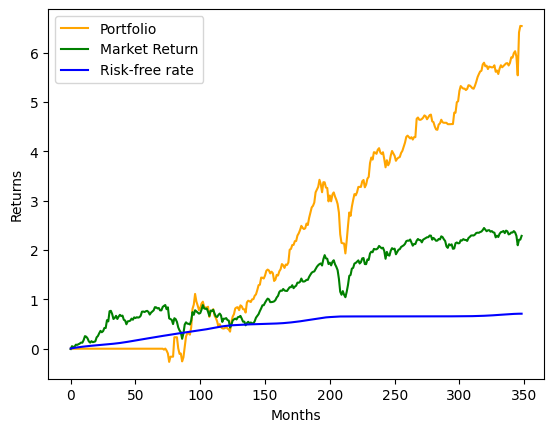

In [184]:
cumulative_rf = np.cumsum(monthly_fixed_params["RF"])
cumulative_ret = np.cumsum(portfolio_returns.fillna(0))
cumulative_MktRF = np.cumsum(monthly_fixed_params["MktRF"])

plt.plot(cumulative_ret, label='Portfolio', color = 'orange')
plt.plot(cumulative_MktRF, label='Market Return', color = 'green')
plt.plot(cumulative_rf, label='Risk-free rate', color = 'blue')
plt.xlabel('Months')
plt.ylabel('Returns')
plt.legend()
plt.show()